In [14]:
# Завдання 2.
# Розробитии варіаційний автокодувальник 
# для датасету рукописних цифр MNIST на основі
# багатошарової моделі. Побудувати функцію втрат. 
# Візуалізацію розпізнавання. Порівняти результати із звичайним автокодувальником.


import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist


In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворення входів в діапазон [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_dim = 784  # розмір зображення = 28x28

# Варіаційний автокодувальник


inputs = Input(shape=(input_dim,))

# Кодер
h = Dense(512, activation='relu')(inputs)
z_mean = Dense(2)(h)
z_log_var = Dense(2)(h)

# Параметри варіаційного автокодувальника
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Репараметризація
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

# Декодер
decoder_h = Dense(512, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Компіляція 

vae = Model(inputs, x_decoded_mean)
vae.compile(optimizer='adam', loss='binary_crossentropy')

def vae_loss(inputs, x_decoded_mean):
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss


# Навчання 

vae.fit(x_train, x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))

# Побудова варіаційного автокодувальника для візуалізації реконструкції

encoder = Model(inputs, z_mean)

# Вибірка цифр з тестового датасету та їх реконструкція
encoded_imgs = encoder.predict(x_test)
decoded_imgs = vae.predict(x_test)




Epoch 1/20
469/469 [==============================] - 4s 7ms/step - loss: 0.2400 - val_loss: 0.2120
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2068 - val_loss: 0.2023
Epoch 3/20
469/469 [==============================] - 4s 9ms/step - loss: 0.1998 - val_loss: 0.1979
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1961 - val_loss: 0.1951
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1937 - val_loss: 0.1930
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1917 - val_loss: 0.1914
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1899 - val_loss: 0.1898
Epoch 8/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1884 - val_loss: 0.1887
Epoch 9/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1871 - val_loss: 0.1878
Epoch 10/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1861 - val_loss: 0.1865

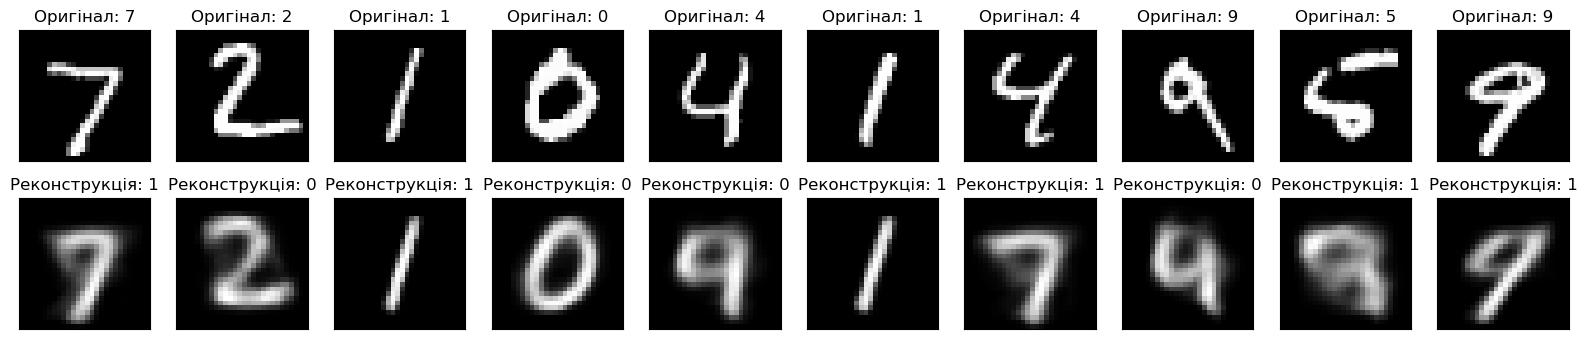

In [16]:
# зображення

n = 10  

plt.figure(figsize=(20, 4))
for i in range(n):
    # Оригінальні зображення
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Оригінал: {y_test[i]}')  

    
    # Реконструйовані зображення
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Реконструкція: {np.argmax(encoded_imgs[i])}')  
plt.show()
